In [1]:
!pip install matplotlib z3-solver python-sat[aiger,approxmc,cryptosat,pblib]

# Encoding Constraints

The first step is to find and declare all the contraints in the game Suduko. Our team found:

C1 = Each cell on the Sudoku board has one value

C2 = Each value (v) in a cell is 1 <= v <= N

C3 = Each row has all numbers from 1 to N

C4 = Each column has all numbers from 1 to N

C5 = Each subgrid has all numbers from 1 to N

To set up the rest of our project we must encode each contrainst and & them all together to get a total CNF of the given Suduko puzzle.


## Variables for PairWise

For us to begin encoding we must have a way to represent each cell in the puzzle. Instead of being an integer from the puzzle, we can use the cells position and value to make a unique number. For determining a variable, we have four parameters:

r - The row of the cell

c - The column of the cell

v - The possible value of the cell.

N - The complete size of the suduko puzzle

Although r, c, and n are needed for obvious reasons, we must add the parameter v to allow us to represent the whole problem. What I mean by that is in a Boolean SAT problem, we must encode all possiblities a cell can have. r and c allow us to find the position of each cell, but v allows us to represent possible the values of 1 to N. Thus, v allows us to create N boolean variables for each cell. Only, boolean variables in this case positive numbers for truth and negative numbers for false.

In [2]:
from pysat.solvers import Solver

# We will call this function to generate a unique variable (integer)
# to represent the case of a cell at row r, column c, with value v
def var(r, c, v, N):

    # Assertion statements to help debug and make sure we never have a row, col., or val that breaks index
    assert(1 <= r and r <= N)
    assert(1 <= c and c <= N)
    assert(1 <= v and v <= N)
    return (r-1)*N*N+(c-1)*N+(v-1)+1

# We do a plus one as a 0 can cause trouble in CNF literals as they negate our var number by making them negative

## Varibles for Sequential Counters

For generating the variables when using sequential counters it's a bit more tricky. Instead of just having one varible to represent a possibility we now also have auxillary variables that can depend on one another. As you can see, we have differents ones for X (regular possibility), R for row aux, C for column aux, and B and Block aux.

In [3]:
var_map = {}

def var_id(prefix, *args):
    key = (prefix,) + tuple(args)
    if key not in var_map:
        var_map[key] = len(var_map) + 1
    return var_map[key]

# Return unique ID for each variable
def var_X(r, c, v): return var_id("X", r, c, v)
def var_R(r, v, c): return var_id("R", r, v, c)
def var_C(c, v, r): return var_id("C", c, v, r)
def var_B(b, v, i): return var_id("B", b, v, i)
def var_A(v, c, r): return var_id("A", v, c, r)

def get_var_name_map():
    # Reverse lookup from ID to (prefix, *args)
    reverse_map = {v: k for k, v in var_map.items()}
    return reverse_map

def print_var_map():
    reverse = get_var_name_map()
    for var_id in sorted(reverse):
        print(f"{var_id}: {reverse[var_id]}")

## Creation of CNF constriants for Pairwise

Now comes the major step of creating the clauses based on each constraint we identified prior to this. Below is the function we will call in order to set up our cnf structure, which is basically a list of lists. Each inner list is a clause of some sort like making sure each row has all values. The proper way to think of this representation is lists like $ [X_1, X_2, ..., X_N] $ ∧ $ [-X_1, -X_2] $ are conjuctive while the inside of each list is disjunctive by ∨.

Note: This is our second version of encoding the constraints. The previous version was more unreadable and ultimately failed on simple tests. One of the small things we did was 1 based index which made the code more easy to follow.

<!-- NOTE: Looking at the code, you will notice that we don't have constraint 2 encoded in its own block like the rest of the constraints. Instead we this constraint is enforced by our use of N for the lengths of our loops. It is impossible for us to go above the value N if we only have loops going to N. -->

In [4]:
from pysat.formula import CNF

def generate_CNF_constraints_pairwise(N):

    # n will represent the sub grid length, N represents the full puzzle length
    n = N * N

    # Using the PYSAT library, we can use the cnf object to store all of our clauses
    cnf = CNF()

    # Iterate through all cells of the puzzle
    for r in range(1, n + 1):
        for c in range(1, n + 1):

            # This represents adding clauses for C1
            # Each suduko cell must have a value
            cnf.append([var(r, c, v, n) for v in range(1, n + 1)])

            # Iterate over possible values
            for v in range(1, n + 1):
                for x in range(v + 1, n + 1):

                    # This represents adding clauses for C2
                    # Each cell can hold only one value
                    cnf.append([-var(r, c, v, n), -var(r, c, x, n)])

    # Iterate over all possibel values
    for v in range(1, n + 1):

        # This represents clauses for C3
        # Each row must have one of each value
        for r in range(1, n + 1):
            cnf.append([var(r, c, v, n) for c in range(1, n + 1)]) # We use c here to iterate through a row

        # This represents clauses for C4
        # Each column must have one of each value
        for c in range(1, n + 1):
            cnf.append([var(r, c, v, n) for r in range(1, n + 1)])

        # This represents clauses for C5
        # Each n x n block must have one of each value
        for br in range(0, N):
            for bc in range(0, N):
                cnf.append([var(br * N + rd, bc * N + cd, v, n) for rd in range(1, N + 1) for cd in range(1, N + 1)])
    print(len(cnf.clauses))

    # Return the clauses we created
    return cnf

In [5]:
cnf = generate_CNF_constraints_pairwise(10)

49540000


## Creation of CNF constraints for Sequential Counters

Sequential counters requires that we follow three basic rules;

Rule 1: If our number is true for a given cell, then all of the sequential counters involved with this cell need to know.

~X(r,c, v) V S(r,v,c)

Rule 2: Once we realize a sequntial counter is true, it must stay true to tell the others.

~S(r, v, c-1) V S(r, v, c)

Rule 3: We must prevent other cells within this row, column, or block from claiming the same value v.


~X(r, c, v) V ~S(r, v, c-1)

These three rules must be implemented for each and every constraint we defined.

In [6]:
# This is a helper function just to simply help us get the index of blocks throughout the puzzle

def generate_blocks(N):
    """
    Generate a mapping from block index (starting at 1) to a list of (r, c) cells in that block.
    Assumes blocks are laid out left-to-right, top-to-bottom.

    Example: N = 3 → 9x9 puzzle → 9 blocks, each 3x3
    """
    N2 = N * N
    blocks = {}
    block_index = 1 # Once again making this index one based for consistency

    # Code block that essentially makes a dictionary with block ids as keys
    # and a list of cells as the cells corresponding to the block

    for block_row in range(N):
        for block_col in range(N):
            blocks[block_index] = []
            for dr in range(N):
                for dc in range(N):
                    r = block_row * N + dr + 1
                    c = block_col * N + dc + 1
                    blocks[block_index].append((r, c))
            block_index += 1

    return blocks

In [7]:
# Function called to generate constraints using sequential counters

def generate_cnf_constraints_sequential_counters(N, solver):

    n = N * N

    # The cnf here is just to help us count clauses
    cnf = CNF()

    # Having the blocks dictionary makes it easier to know which sub grid a cell belongs too
    blocks = generate_blocks(N)  # map of block number → list of (r, c) pairs

    for r in range(1, n + 1):
        for c in range(1, n + 1):
            # At least one value
            clause = [var_X(r, c, v) for v in range(1, n + 1)] # C1 does not use sequential counters because it can't
            solver.add_clause(clause)
            cnf.append(clause)

            # At most one value

            for v in range(1, n + 1):
                x = var_X(r, c, v)
                a = var_A(r, c, v) # We needed an auxillary variable type for C2, and just A

                # Rule 1: ~X ∨ A
                solver.add_clause([-x, a])
                cnf.append([-x, a])

                if v > 1:
                    a_prev = var_A(r, c, v - 1)

                    # Rule 2: ~A_prev ∨ A
                    solver.add_clause([-a_prev, a])
                    cnf.append([-a_prev, a])

                    # Rule 3: ~X ∨ ~A_prev
                    solver.add_clause([-x, -a_prev])
                    cnf.append([-x, -a_prev])
    # print(len(cnf.clauses))

    # Generates cnf formulas for row constraint
    for r in range(1, n + 1):
        for v in range(1, n + 1):
            for c in range(1, n + 1):
                x = var_X(r, c, v)
                R = var_R(r, v, c)

                # Rule [1]: ~X(r,c,v) ∨ R(r,v,c)
                solver.add_clause([-x, R])
                cnf.append([-x, R])

                if c > 1:
                    r_prev = var_R(r, v, c - 1)

                    # Rule [2]: ~R(r,v,c-1) ∨ R(r,v,c)
                    solver.add_clause([-r_prev, R])
                    cnf.append([-r_prev, R])

                    # Rule [3]: ~X(r,c,v) ∨ ~R(r,v,c-1)
                    solver.add_clause([-x, -r_prev])
                    cnf.append([-x, -r_prev])
    # print(len(cnf.clauses))

    # Generates cnf formulas for column constraints
    for c in range(1, n + 1):
        for v in range(1, n + 1):
            for r in range(1, n + 1):
                x = var_X(r, c, v)
                C = var_C(c, v, r)

                # Rule [1]: ~X(r,c,v) ∨ C(c,v,r)
                solver.add_clause([-x, C])
                cnf.append([-x, C])

                if r > 1:
                    c_prev = var_C(c, v, r - 1)

                    # Rule [2]: ~C(c,v,r-1) ∨ C(c,v,r)
                    solver.add_clause([-c_prev, C])
                    cnf.append([-c_prev, C])

                    # Rule [3]: ~X(r,c,v) ∨ ~C(c,v,r-1)
                    solver.add_clause([-x, -c_prev])
                    cnf.append([-x, -c_prev])
    # print(len(cnf.clauses))

    for b in range(1, n + 1):
      cells = blocks[b]  # list of (r, c) tuples
      for v in range(1, n + 1):
          for i, (r, c) in enumerate(cells, start=1):
              x = var_X(r, c, v)
              s = var_B(b, v, i)

              # Rule [1]: ~X(r,c,v) ∨ B(b,v,i)
              solver.add_clause([-x, s])
              cnf.append([-x, s])

              if i > 1:
                  s_prev = var_B(b, v, i - 1)

                  # Rule [2]: ~B(b,v,i-1) ∨ B(b,v,i)
                  solver.add_clause([-s_prev, s])
                  cnf.append([-s_prev, s])

                  # Rule [3]: ~X(r,c,v) ∨ ~B(b,v,i-1)
                  solver.add_clause([-x, -s_prev])
                  cnf.append([-x, -s_prev])
    # print(len(cnf.clauses))

    return cnf

In [8]:
from pysat.solvers import Glucose4

var_map = {}
cnf = generate_cnf_constraints_sequential_counters(3, Glucose4())
print(len(cnf.clauses))

8181


## Encoding the puzzle

Now that we have the rules of suduko for every single cell encoded into our cnf object, we now need to know how to take in a puzzle and encode it. To keep things simple, the puzzle will simply be a 2D array filled with clues and making all starting blank spaces 0. A "clue" is one of the numbers a suduko puzzle starts out with. Each clue needs to be encoded as a clause. The clause can just be a single postive literal to represent a position having that exact value.

In [9]:
def add_clues(puzzle, n, cnf):
    N = n * n

    # Go through all cells in the N x N grid
    for r in range(1, N+1):
        for c in range(1, N+1):
            v = puzzle[r-1][c-1]
            if v != 0: # If its a zero, we consider it to be blank and will skip over it
                # We do a -1 as CNF formulas are 0 based
                # The first possible value should be mapped to 0
                cnf.append([var(r, c, v, N)])

    # Return our cnf with new clauses obtained from our clues added
    return cnf

In [10]:
def add_clues_sequential(puzzle, n, solver):
    N = n * n

    # Go through all cells in the N x N grid
    for r in range(1, N+1):
        for c in range(1, N+1):
            v = puzzle[r-1][c-1]
            if v != 0: # If its a zero, we consider it to be blank and will skip over it
                # We do a -1 as CNF formulas are 0 based
                # The first possible value should be mapped to 0
                solver.add_clause([var_X(r, c, v)])

    # Return our cnf with new clauses obtained from our clues added
    return solver

## Decoding our clauses (Pairwise)

Knowing the formula for encoding variables, we can reverse it to figure out the exact row, column, and value. This allows us to create the solution from the variables that are True.

In [11]:
def decode_var(x, N):
    x -= 1  # Shift down because original encoding adds 1
    r = x // (N * N) + 1
    c = (x // (N)) % N + 1
    v = (x % N) + 1
    return (r, c, v)

## Decoding our clauses (Sequential Counters)

Since we created a global var_map to contain all the variables we have, we no longer need to reverse a formula with computation. Instead, we can just do a look up for all the varibles that are confirmed and return them.

In [12]:
def decode_model(model):
    """
    Given a SAT solver model (list of integers), decode the True variables
    using the global `var_map` structure.
    Returns a list of readable variable tuples.
    """
    reverse_map = get_var_name_map()
    true_vars = []

    for var in model:
        if var > 0 and var in reverse_map:
            decoded = reverse_map[var]
            true_vars.append(decoded)

    return true_vars

## Creation of Suduko boards

Given the scope of the project is to see how far we can push N to be, we can't just use premade puzzles of size 9x9. Instead, we had to formulate our own functions to create a suduko puzzles of any size that still follow the rules of suduko. How we will use these functions is by creating a full suduko puzzle already filled in 100%, and then remove cells at random to then let our algorithms solve. This method allows us to already know the solution which makes it easy to determine the accuracy of our results.

In [13]:
import random

# Determines the value to be placed at position (r, c) based on a base pattern.
def pattern(r, c, base):
    return (base * (r % base) + r // base + c) % (base * base)

# Returns a shuffled version of the input sequence.
def shuffle(s):
    s = list(s)  # Convert to list (in case input is a range or tuple)
    random.shuffle(s)
    return s

# Generates a full Sudoku board of size (base^2 x base^2)
def generate_full_board(size, base):
    numbers = list(range(1, size + 1))  # The digits to fill in the Sudoku grid

    # Create a randomized order of rows and columns based on the base
    rows = [g * base + r for g in shuffle(range(base)) for r in shuffle(range(base))]
    cols = [g * base + c for g in shuffle(range(base)) for c in shuffle(range(base))]

    nums = shuffle(numbers)  # Shuffle the digits to make a random valid board

    # Generate the board using the base pattern and shuffled values
    board = [[nums[pattern(r, c, base)] for c in cols] for r in rows]
    return board

# Creates a Sudoku puzzle by removing cells from the full board based on a removal rate
def remove_cells(board, removal_rate=0.5):
    size = len(board)
    puzzle = [row.copy() for row in board]  # Make a deep copy to preserve original board

    # Randomly remove cells by setting them to 0 (typically represents empty cells in Sudoku)
    for r in range(size):
        for c in range(size):
            if random.random() < removal_rate:
                puzzle[r][c] = 0
    return puzzle

## Testing Metric Utility Functions

To help with data gathering, below is a function to compute the board accuracy metric (number of correct cells / total cells).

In [14]:
def get_accuracy(answer, solution):
    assert len(answer) == len(solution), f"Mismatch in answer/solution row count; answer: {len(answer)}, solution: {len(solution)}"
    total = 0
    correct = 0
    for r in range(0, len(solution)):
        assert len(answer[r]) == len(solution[r]), f"Mismatch in answer/solution in column count of row {r}; answer: {len(answer[r])}, solution: {len(solution[r])}"
        for c in range(0, len(solution[r])):
            total += 1
            if answer[r][c] == solution[r][c]:
                correct += 1
            else:
              pass
                # print(f"mismatch at ({r}, {c}) -- expected {solution[r][c]}, got {answer[r][c]}")

    return correct / total

## Wrapper Classes for Testing

Below you will find functions for effectively creating our cnf formulas, using a SAT solver, using a decoder, finding the solution, and reporting the accuracy of each algorithm. This will make our testing phase very easy as we just have to do a simple function call to test different Ns for different puzzles.

In [15]:
# Helper function for creating a 2D array out of all the True (X) variables

def extract_solution(model, N):
    solution = [[0 for _ in range(N)] for _ in range(N)]
    for val in model:
        if val > 0:
            r, c, v = decode_var(val, N)
            if r is not None:
                solution[r - 1][c - 1] = v
    return solution

In [16]:
# Helper function for turning the Sequential Counters solution into a 2D array

def model_to_grid(solution, N):
    grid = [[0 for _ in range(N*N)] for _ in range(N*N)]
    for (_, r, c, v) in solution:
        grid[r - 1][c - 1] = v
    return grid

In [17]:
import time
from pysat.solvers import Glucose4

def solve_sudoku_pairwise(n, full_solution, puzzle):
    start_time = time.process_time_ns()
    cnf = generate_CNF_constraints_pairwise(n)
    cnf = add_clues(puzzle, n, cnf)
    solver = Glucose4()
    solver.append_formula(cnf)

    if solver.solve():
        end_time = time.process_time_ns() - start_time
        model = solver.get_model()
        N = n * n
        solution = [[0 for _ in range(N)] for _ in range(N)]

        # Go through our solution model fill in our 2d array by decoding each varaible
        for val in model:
            if val > 0:
                r, c, v = decode_var(val, N)
                # print(r, c, v)
                solution[r-1][c-1] = v  # Add 1 to match 1-9 output

        # Prints our solution
        for row in solution:
            print(" ".join(str(num) for num in row))

        solution_2D = extract_solution(model, N)
        return {
            "accuracy": get_accuracy(full_solution, solution_2D),
            "clauses": len(cnf.clauses),
            "time": end_time
        }
    else:
        end_time = time.process_time_ns() - start_time
        print("No solution found.")
        return {
            "accuracy": None,
            "clauses": len(cnf.clauses),
            "time": end_time
        }
        # print("Total clauses:", len(cnf.clauses))

n = 3
full_solution = generate_full_board(n*n, n)
puzzle = remove_cells(full_solution, removal_rate=0.5)
solve_sudoku_pairwise(n, full_solution, puzzle)



3240
1 2 4 9 6 5 3 7 8
3 7 8 1 2 4 9 6 5
9 6 5 3 7 8 1 2 4
8 3 2 4 1 6 5 9 7
5 9 7 8 3 2 4 1 6
4 1 6 5 9 7 8 3 2
2 8 1 6 4 9 7 5 3
7 5 3 2 8 1 6 4 9
6 4 9 7 5 3 2 8 1


{'accuracy': 1.0, 'clauses': 3284, 'time': 5794700}

In [18]:
import time

def solve_sudoku_sequential_counters(n, full_solution, puzzle):
    var_map = {} # The way we did our encoding and decoding requires a new var_map for each puzzle
    solver = Glucose4()
    start_time = time.process_time_ns()
    cnf = generate_cnf_constraints_sequential_counters(n, solver)
    # print(len(cnf.clauses))
    add_clues_sequential(puzzle, n, solver)
    # print(len(cnf.clauses))
    # solver.append_formula(cnf)

    if solver.solve():
        end_time = time.process_time_ns() - start_time
        model = solver.get_model()
        solution = [var for var in decode_model(model) if var[0] == "X"]

        grid = [[0 for _ in range(n*n)] for _ in range(n*n)]

        for (_, r, c, v) in solution:
            grid[r - 1][c - 1] = v

        # Print grid
        line = "+".join(["-" * (2 * n - 1)] * n)

        for i, row in enumerate(grid):
            row_str = " | ".join(
                " ".join(f"{val:2}" if val != 0 else " ." for val in row[j:j + n])
                for j in range(0, n*n, n)
            )
            print(row_str)
            if (i + 1) % n == 0 and i + 1 < n*n:
                print(line)

        solution_2D = model_to_grid(solution, n)
        return {
            "accuracy": get_accuracy(full_solution, solution_2D),
            "clauses": len(cnf.clauses),
            "time": end_time
        }
    else:
        end_time = time.process_time_ns() - start_time
        print("No solution found.")
        return {
            "accuracy": None,
            "clauses": len(cnf.clauses),
            "time": end_time
        }
        # print("Total clauses:", len(cnf.clauses))


n=5
full_solution = generate_full_board(n*n, n)
puzzle = remove_cells(full_solution, removal_rate=0.5)
result = solve_sudoku_sequential_counters(n, full_solution, puzzle)
print(result["accuracy"], result["time"], result["clauses"])
print(full_solution)

 6 14  5  2 16 |  1 23  3 17  8 |  9 21  4 12 15 | 20 24 13 18 25 | 19 10 22 11  7
 3  1 23 17  8 |  9 12 21  4 15 | 10 19  7 11 22 | 14  5  2 16  6 | 25 20 18 24 13
21  9 24  4 15 | 10 11 19  7 22 | 20 16 13 25 18 |  1 23 17  8  3 | 12 14  6  5  2
12 20 18 13 25 | 14  5  6  2 16 |  1  3 17 24  8 | 10 11  7 22 19 | 21  9 15 23  4
19 10 11  7 22 | 20 24 25 13 18 | 14  6  2  5 23 |  9 12  4 15 21 |  3  1  8 16 17
---------+---------+---------+---------+---------
11  7 22  6 14 | 13 18 24  3  1 |  2  5 21 16  9 |  4 15 25 20 12 | 10 23 19 17  8
 9  4 15 25 20 |  7 22 11  6 14 | 13 24  3 18  1 | 17  8 19 10 23 |  5  2 16 12 21
24 13 12  3 18 |  2 16  5 21 10 | 17 23 19  8 20 |  7 22  6 14 11 |  1  4  9 15 25
23 17  8 19  1 |  4 15 12 25 20 |  7 11  6 22 10 |  2 16 21  9  5 | 24 13 14 18  3
 5  2 16 21 10 | 17  8 23 19  9 |  4 12 25 15 14 | 13 18  3  1 24 | 11  7 20 22  6
---------+---------+---------+---------+---------
15 25 20 24 13 |  6 14 22  5  2 |  3 18 23  1 17 | 19 10 11  7  8 | 16

# Testing

## Main Testing Function

By running all of the cells before this one, we are prepared to test both algorithms with a set of puzzles. The following code cell will complete all tests on 10 unique puzzles across both pairwise and sequential counters.

In [19]:
# @title
from typing import Dict, List, Union, TypedDict

class SudokuResult(TypedDict):
    accuracy: Union[float, None]
    time: int
    clauses: int

puzzles: Dict[int, List[List[List[int]]]] = {}
data: Dict[str, List[Dict[str, Union[int, float]]]] = {}

SEQUENTIAL_STOP_POINT = 6 # runs up to but not including this n
PAIRWISE_STOP_POINT = 5

data["Sequential"] = []
data["Pairwise"] = []

for n in range(2, 10):
    puzzles[n] = [generate_full_board(n*n, n) for _ in range(0, 10)]

for n in puzzles:
    for solution in puzzles[n]:
        puzzle = remove_cells(solution, removal_rate=0.5)

        if n < SEQUENTIAL_STOP_POINT:
            result_sequential = solve_sudoku_sequential_counters(n, solution, puzzle)
            data["Sequential"].append({
                "n": f"{n}",
                "clauses": result_sequential["clauses"],
                "time": result_sequential["time"],
                "accuracy": result_sequential["accuracy"]
            })

        if n < PAIRWISE_STOP_POINT:
            result_pairwise = solve_sudoku_pairwise(n, solution, puzzle)
            data["Pairwise"].append({
                "n": f"{n}",
                "clauses": result_pairwise["clauses"],
                "time": result_pairwise["time"],
                "accuracy": result_pairwise["accuracy"]
            })

        # result_pairwise = solve_pairwise(blah)

        # result backtracking = solve_backtrackign(blah)

    # print(len(puzzles[n]))

# print(data)

 2  3 |  4  1
 1  4 |  3  2
---+---
 3  1 |  2  4
 4  2 |  1  3
160
2 3 4 1
1 4 3 2
3 1 2 4
4 2 1 3
 1  2 |  4  3
 3  4 |  2  1
---+---
 4  1 |  3  2
 2  3 |  1  4
160
1 2 4 3
3 4 2 1
4 1 3 2
2 3 1 4
 2  4 |  1  3
 1  3 |  2  4
---+---
 3  2 |  4  1
 4  1 |  3  2
160
2 4 1 3
1 3 2 4
3 2 4 1
4 1 3 2
 1  2 |  3  4
 4  3 |  2  1
---+---
 3  1 |  4  2
 2  4 |  1  3
160
1 2 3 4
4 3 2 1
3 1 4 2
2 4 1 3
 2  4 |  3  1
 1  3 |  4  2
---+---
 3  2 |  1  4
 4  1 |  2  3
160
2 4 3 1
1 3 4 2
3 2 1 4
4 1 2 3
 2  3 |  4  1
 4  1 |  2  3
---+---
 1  2 |  3  4
 3  4 |  1  2
160
2 3 4 1
4 1 2 3
1 2 3 4
3 4 1 2
 2  1 |  4  3
 3  4 |  1  2
---+---
 1  3 |  2  4
 4  2 |  3  1
160
2 1 4 3
3 4 1 2
1 3 2 4
4 2 3 1
 1  3 |  4  2
 2  4 |  3  1
---+---
 4  1 |  2  3
 3  2 |  1  4
160
1 3 4 2
2 4 3 1
4 1 2 3
3 2 1 4
 1  2 |  3  4
 3  4 |  1  2
---+---
 4  1 |  2  3
 2  3 |  4  1
160
1 2 3 4
3 4 1 2
4 1 2 3
2 3 4 1
 1  4 |  3  2
 3  2 |  1  4
---+---
 2  1 |  4  3
 4  3 |  2  1
160
1 4 3 2
3 2 1 4
2 1 4 3
4 3 2 1


## Graphing Results

The cell below uses the results of the testing function above to get wanted statistics of each algorithm including clause count, completed but invalid puzzles for each n, as well as average accuracy for each n as it increases.

In [20]:
import matplotlib.pyplot as plt
from typing import Dict, List, Union, TypedDict

def plot_data(data: Dict[str, List[Dict[str, Union[int, float]]]]):
    avg_accuracy_per_type = {}

    for curr_type in data:
        # print(f"Processing {curr_type} Data")
        ns = []
        clauses = []

        total_tests_per_n = {}

        times_failed_per_n = {}
        times_succeeded_per_n = {}
        accuracies_per_n = {}
        clauses_per_n = {}

        avg_accuracy_per_n = {}
        avg_clauses_per_n = {}

        for pt in data[curr_type]:
            if str(pt["n"]) not in ns:
                ns.append(str(pt["n"]))

            if total_tests_per_n.get(pt["n"], None) == None:
                total_tests_per_n[pt["n"]] = 0
            total_tests_per_n[pt["n"]] = total_tests_per_n[pt["n"]] + 1

            if times_failed_per_n.get(pt["n"], None) == None:
                times_failed_per_n[pt["n"]] = 0
            if times_succeeded_per_n.get(pt["n"], None) == None:
                times_succeeded_per_n[pt["n"]] = 0
            if pt["accuracy"] == 1.0:
                times_succeeded_per_n[pt["n"]] = times_succeeded_per_n[pt["n"]] + 1
            else:
                times_failed_per_n[pt["n"]] = times_failed_per_n[pt["n"]] + 1

            if clauses_per_n.get(pt["n"], None) == None:
                clauses_per_n[pt["n"]] = []
            clauses_per_n[pt["n"]].append(pt["clauses"])

            if accuracies_per_n.get(pt["n"], None) == None:
                accuracies_per_n[pt["n"]] = []
            accuracies_per_n[pt["n"]].append(pt["accuracy"])

        for n in accuracies_per_n:
            avg_accuracy_per_n[n] = sum(map(float, accuracies_per_n[n])) / len(accuracies_per_n[n])

        for n in clauses_per_n:
            avg_clauses_per_n[n] = sum(clauses_per_n[n]) / len(clauses_per_n[n])

        avg_accuracy_per_type[curr_type] = avg_accuracy_per_n

        # print(ns)
        # print(total_tests_per_n)
        # print(times_failed_per_n)
        # print(avg_accuracy_per_n)
        # print(avg_clauses_per_n)

        # plt.figure(curr_type + " - clauses")
        # fig, ax = plt.subplots()
        # ax.bar(ns, clauses, width=1, edgecolor="white", linewidth=0.7)
        # # ax.legend(["asdf"])
        # ax.set_xlabel("Subgrid Length")
        # ax.set_ylabel("Num. of Clauses")
        # ax.set_title(f"{curr_type} - Number of Clauses")
        # plt.show()
        # plt.close()

        # plt.figure("Average Accuracy By Solver Type")
        # fig, ax = plt.subplots()
        # ax.plot(avg_accuracy_per_n.keys(), avg_accuracy_per_n.values())
        # plt.close()

        plt.figure(curr_type + " - Num Times Failed")
        fig, ax = plt.subplots()
        ax.bar(times_failed_per_n.keys(), times_failed_per_n.values(), width=1, edgecolor="white", linewidth=0.7)
        ax.set_xlabel("Subgrid Length")
        ax.set_ylabel(f"Tests Failed (Out of {total_tests_per_n['2']})")
        ax.set_title(f"{curr_type} - Tests Failed out of {total_tests_per_n['2']}")
        plt.show()
        plt.close()

        plt.figure(curr_type + " - Avg Accuracy")
        fig, ax = plt.subplots()
        ax.bar(avg_accuracy_per_n.keys(), avg_accuracy_per_n.values(), width=1, edgecolor="white", linewidth=0.7)
        ax.set_xlabel("Subgrid Length")
        ax.set_ylabel("Average Accuracy")
        ax.set_title(f"{curr_type} - Average Accuracy per n")
        plt.show()
        plt.close()

    plt.figure("Average Accuracy By Solver Type")
    fig, ax = plt.subplots()
    for curr_type in avg_accuracy_per_type:
        avg_accuracy_per_n = avg_accuracy_per_type[curr_type]
        ax.plot(avg_accuracy_per_n.keys(), avg_accuracy_per_n.values())
    ax.legend(avg_accuracy_per_type.keys())
    ax.set_xlabel("Subgrid Length")
    ax.set_ylabel("Average Accuracy")
    ax.set_title("Average Accuracy by Solver Type")
    plt.show()
    plt.close()

<Figure size 640x480 with 0 Axes>

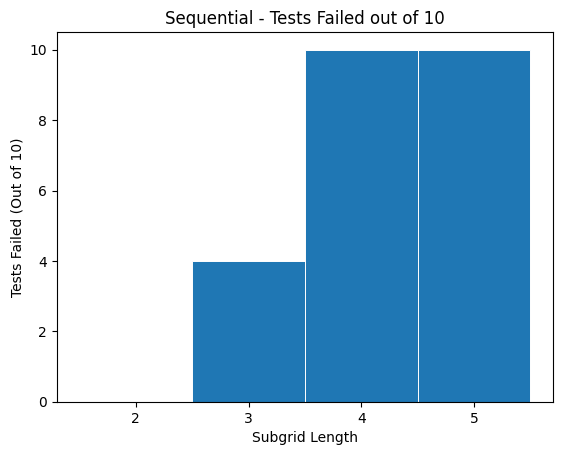

<Figure size 640x480 with 0 Axes>

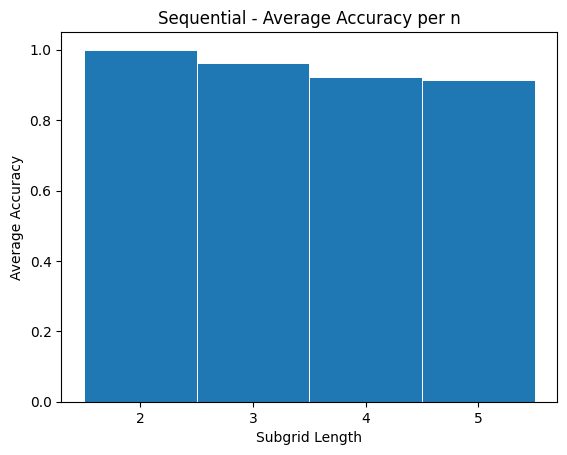

<Figure size 640x480 with 0 Axes>

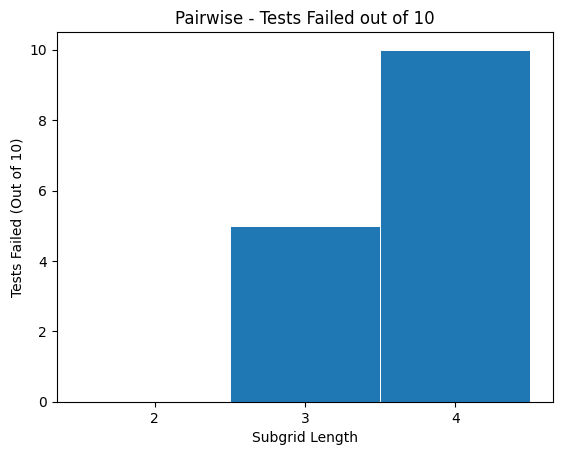

<Figure size 640x480 with 0 Axes>

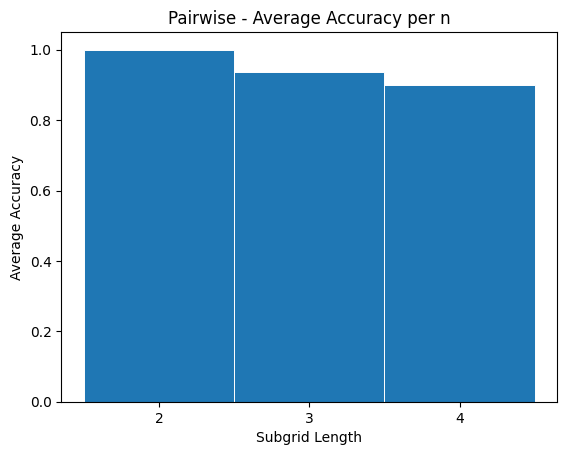

<Figure size 640x480 with 0 Axes>

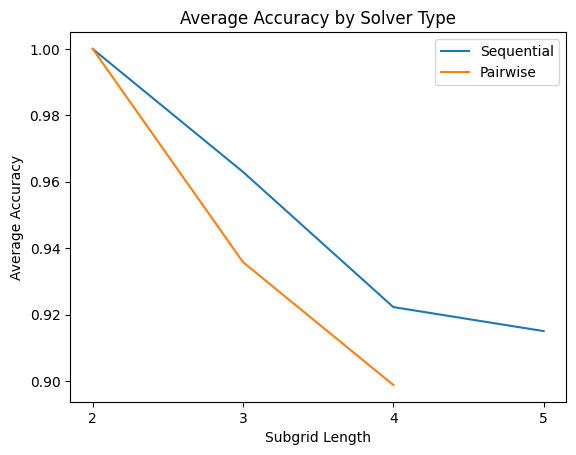

In [21]:
plot_data(data)

## Preprocessing Code

Below is all the code that enables preprocesessing combined with sequential counters. We've broken it down into creating domains, generating cnf formulas, packaging it into a single function, and then testing it across multiple puzzles of size n. Much of the code is reused from the sequential counters code above such as the encoding of varaibles and decoding of the solution.

In [22]:
def preprocess_domains(N, board):
    n = N * N

    # Create initial domain with each cell having full domain 1 - n
    domains = [[set(range(1, n + 1)) for _ in range(n)] for _ in range(n)]

    # Set initial domains based on given board
    # Basically if a cell is filled, its domain of possibilties is set to one value
    for r in range(n):
        for c in range(n):
            if board[r][c] != 0:
                domains[r][c] = {board[r][c]}

    # Constraint propagation: naked singles
    changed = True # We run this loop until no domain is changed to know we are done
    while changed:
        changed = False

        # Iterate through cells of the baord
        for r in range(n):
            for c in range(n):
                # If a cell only has one value in its domain, its a clue and its correct
                if len(domains[r][c]) == 1:
                    val = next(iter(domains[r][c]))

                    # This for loop shrinks cell domains based on the clue we already have
                    for i in range(n):

                        # Row value elimination
                        if i != c and val in domains[r][i]:
                            domains[r][i].discard(val)
                            changed = True
                        # Column value elimination
                        if i != r and val in domains[i][c]:
                            domains[i][c].discard(val)
                            changed = True

                    # Block value elimination

                    # Find the top left cell of a block and then iterate through the rest
                    block_r = (r // N) * N
                    block_c = (c // N) * N
                    for i in range(block_r, block_r + N):
                        for j in range(block_c, block_c + N):
                            if (i, j) != (r, c) and val in domains[i][j]:
                                domains[i][j].discard(val)
                                changed = True
    # Returns a two grid of sets to represent the possible values a cell can contain given the clues
    return domains

In [23]:
def generate_cnf_constraints_sc_preprocessing(N, solver, board):

    n = N * N
    cnf = CNF()
    domains = preprocess_domains(N, board)  # returns domains[r][c] = set of possible values
    blocks = generate_blocks(N)  # map of block number → list of (r, c) pairs

    # 1. Cell Constraints: Each cell gets exactly one value (domain-aware)
    for r in range(1, n + 1):
        for c in range(1, n + 1):
            domain = domains[r - 1][c - 1]
            if not domain:
                raise ValueError(f"Inconsistent puzzle: cell ({r},{c}) has no valid values")

            # At least one value
            clause = [var_X(r, c, v) for v in domain]
            solver.add_clause(clause)
            cnf.append(clause)

            # At most one value: use pairwise or sequential only over valid values
            domain_list = sorted(domain)
            for i in range(len(domain_list)):
                for j in range(i + 1, len(domain_list)):
                    solver.add_clause([-var_X(r, c, domain_list[i]), -var_X(r, c, domain_list[j])])
                    cnf.append([-var_X(r, c, domain_list[i]), -var_X(r, c, domain_list[j])])
    print("After cell constraints:", len(cnf.clauses))

    # 2. Row Constraints: Each number appears at most once per row
    for r in range(1, n + 1):
        for v in range(1, n + 1):
            row_cells = []
            for c in range(1, n + 1):

                # Instead of iterating through all values 1- n,
                # iterate through only possible values (this cells domain)
                if v in domains[r - 1][c - 1]:
                    x = var_X(r, c, v)
                    R = var_R(r, v, c)
                    solver.add_clause([-x, R])
                    cnf.append([-x, R])
                    row_cells.append((x, R))

                    if c > 1:
                        prev_c = c - 1
                        if v in domains[r - 1][prev_c - 1]:
                            r_prev = var_R(r, v, prev_c)
                            solver.add_clause([-r_prev, R])
                            solver.add_clause([-x, -r_prev])
                            cnf.append([-r_prev, R])
                            cnf.append([-x, -r_prev])
    print("After row constraints:", len(cnf.clauses))

    # 3. Column Constraints: Each number appears at most once per column
    for c in range(1, n + 1):
        for v in range(1, n + 1):
            for r in range(1, n + 1):
                if v in domains[r - 1][c - 1]:
                    x = var_X(r, c, v)
                    C = var_C(c, v, r)
                    solver.add_clause([-x, C])
                    cnf.append([-x, C])

                    if r > 1 and v in domains[r - 2][c - 1]:
                        c_prev = var_C(c, v, r - 1)
                        solver.add_clause([-c_prev, C])
                        solver.add_clause([-x, -c_prev])
                        cnf.append([-c_prev, C])
                        cnf.append([-x, -c_prev])
    print("After column constraints:", len(cnf.clauses))

    # 4. Block Constraints: Each number appears at most once per block
    for b in range(1, n + 1):
        cells = blocks[b]
        for v in range(1, n + 1):
            block_cells = [(r, c) for (r, c) in cells if v in domains[r - 1][c - 1]]
            for i, (r, c) in enumerate(block_cells, start=1):
                x = var_X(r, c, v)
                s = var_B(b, v, i)
                solver.add_clause([-x, s])
                cnf.append([-x, s])

                if i > 1:
                    s_prev = var_B(b, v, i - 1)
                    solver.add_clause([-s_prev, s])
                    solver.add_clause([-x, -s_prev])
                    cnf.append([-s_prev, s])
                    cnf.append([-x, -s_prev])
    print("After block constraints:", len(cnf.clauses))

    return cnf

In [24]:
def solve_sudoku_sc_preprocessing(n, full_solution, puzzle):
    var_map = {}
    solver = Glucose4()
    start_time = time.process_time_ns()
    cnf = generate_cnf_constraints_sc_preprocessing(n, solver, puzzle)
    # print(len(cnf.clauses))
    add_clues_sequential(puzzle, n, solver)
    # print(len(cnf.clauses))
    # solver.append_formula(cnf)

    if solver.solve():
        end_time = time.process_time_ns() - start_time
        model = solver.get_model()
        solution = [var for var in decode_model(model) if var[0] == "X"]

        grid = [[0 for _ in range(n*n)] for _ in range(n*n)]

        for (_, r, c, v) in solution:
            grid[r - 1][c - 1] = v

        # Print grid
        line = "+".join(["-" * (2 * n - 1)] * n)

        for i, row in enumerate(grid):
            row_str = " | ".join(
                " ".join(f"{val:2}" if val != 0 else " ." for val in row[j:j + n])
                for j in range(0, n*n, n)
            )
            print(row_str)
            if (i + 1) % n == 0 and i + 1 < n*n:
                print(line)

        solution_2D = model_to_grid(solution, n)
        return {
            "accuracy": get_accuracy(solution_2D, full_solution),
            "clauses": len(cnf.clauses),
            "time": end_time
        }
    else:
        end_time = time.process_time_ns() - start_time
        print("No solution found.")
        return {
            "accuracy": None,
            "clauses": len(cnf.clauses),
            "time": end_time
        }
        # print("Total clauses:", len(cnf.clauses))

data["Sequential w/ Preprocessing"] = []

for n in puzzles:
    for solution in puzzles[n]:
        puzzle = remove_cells(solution, removal_rate=0.5)
        result = solve_sudoku_sc_preprocessing(n, solution, puzzle)
        data["Sequential w/ Preprocessing"].append({
            "n": f"{n}",
            "clauses": result["clauses"],
            "time": result["time"],
            "accuracy": result["accuracy"]
        })

After cell constraints: 16
After row constraints: 32
After column constraints: 48
After block constraints: 64
 2  3 |  4  1
 1  4 |  3  2
---+---
 3  1 |  2  4
 4  2 |  1  3
After cell constraints: 16
After row constraints: 32
After column constraints: 48
After block constraints: 64
 1  2 |  4  3
 3  4 |  2  1
---+---
 4  1 |  3  2
 2  3 |  1  4
After cell constraints: 16
After row constraints: 32
After column constraints: 48
After block constraints: 64
 2  4 |  1  3
 1  3 |  2  4
---+---
 3  2 |  4  1
 4  1 |  3  2
After cell constraints: 16
After row constraints: 32
After column constraints: 48
After block constraints: 64
 1  2 |  3  4
 4  3 |  2  1
---+---
 3  1 |  4  2
 2  4 |  1  3
After cell constraints: 34
After row constraints: 84
After column constraints: 142
After block constraints: 200
 1  4 |  3  2
 3  2 |  4  1
---+---
 2  3 |  1  4
 4  1 |  2  3
After cell constraints: 16
After row constraints: 32
After column constraints: 48
After block constraints: 64
 2  3 |  4  1
 4  

<Figure size 640x480 with 0 Axes>

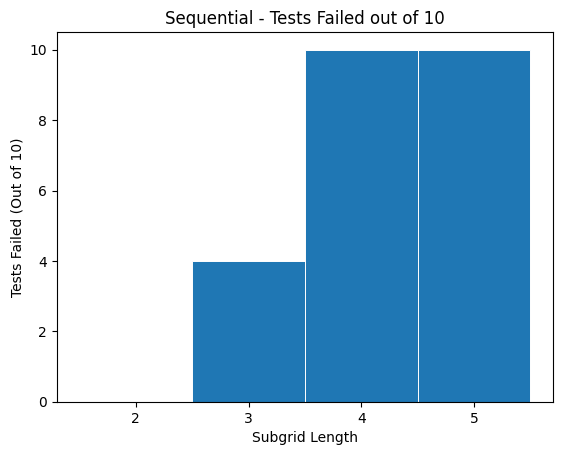

<Figure size 640x480 with 0 Axes>

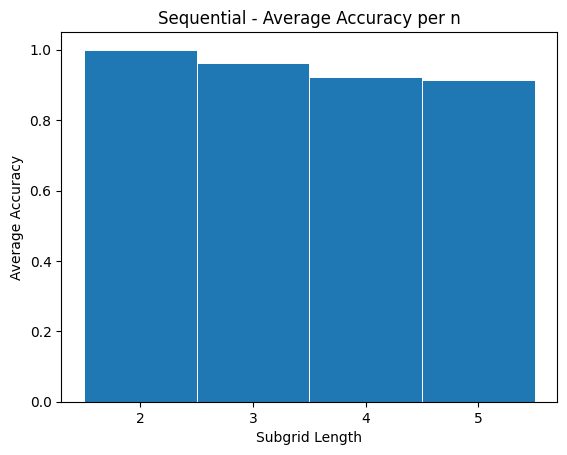

<Figure size 640x480 with 0 Axes>

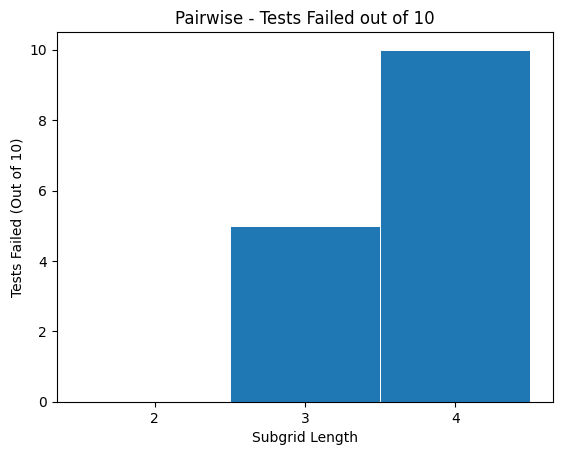

<Figure size 640x480 with 0 Axes>

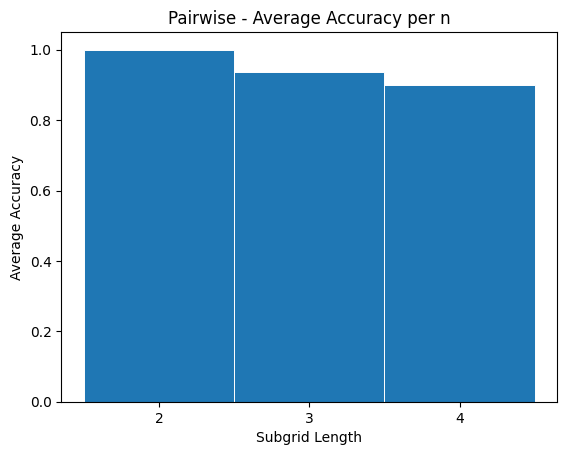

<Figure size 640x480 with 0 Axes>

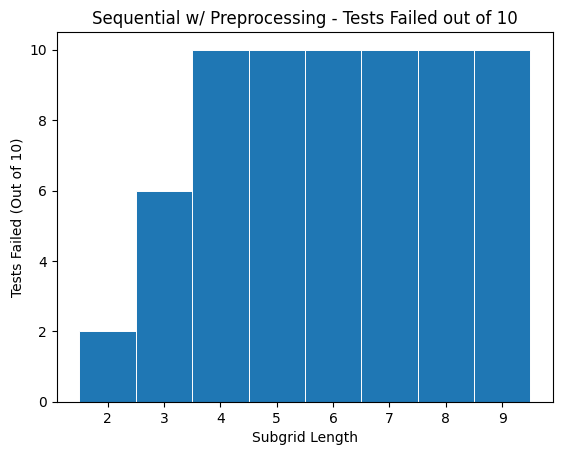

<Figure size 640x480 with 0 Axes>

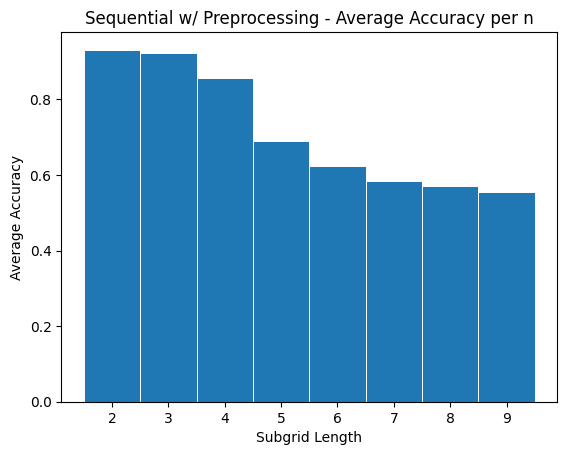

<Figure size 640x480 with 0 Axes>

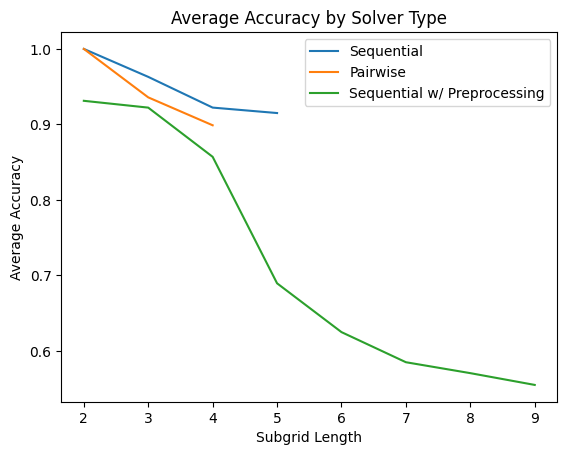

In [25]:
plot_data(data)

# plt.figure("SCP - Avg Accuracy")
# fig, ax = plt.subplots()
# ax.bar(avg_accuracy_per_n.keys(), avg_accuracy_per_n.values(), width=1, edgecolor="white", linewidth=0.7)
# ax.set_xlabel("Subgrid Length")
# ax.set_ylabel("Average Accuracy")
# ax.set_title(f"Sequential with Preprocessing - Average Accuracy per n")
# plt.show()
# plt.close()

In [26]:
!pip install z3-solver

Solving using Z3 (prototype, feel free to modify)

In [27]:
# sudokuboard = []

## Generating a solvable puzzle

For ease of testing, we wrote a short function to generate a fully solved board and and another one to hide some of the obvious solution

In [28]:
# import random

# # Determines the value to be placed at position (r, c) based on a base pattern.
# def pattern(r, c, base):
#     return (base * (r % base) + r // base + c) % (base * base)

# # Returns a shuffled version of the input sequence.
# def shuffle(s):
#     s = list(s)  # Convert to list (in case input is a range or tuple)
#     random.shuffle(s)
#     return s

# # Generates a full Sudoku board of size (base^2 x base^2)
# def generate_full_board(size, base):
#     numbers = list(range(1, size + 1))  # The digits to fill in the Sudoku grid

#     # Create a randomized order of rows and columns based on the base
#     rows = [g * base + r for g in shuffle(range(base)) for r in shuffle(range(base))]
#     cols = [g * base + c for g in shuffle(range(base)) for c in shuffle(range(base))]

#     nums = shuffle(numbers)  # Shuffle the digits to make a random valid board

#     # Generate the board using the base pattern and shuffled values
#     board = [[nums[pattern(r, c, base)] for c in cols] for r in rows]
#     return board

# # Creates a Sudoku puzzle by removing cells from the full board based on a removal rate
# def remove_cells(board, removal_rate=0.5):
#     size = len(board)
#     puzzle = [row.copy() for row in board]  # Make a deep copy to preserve original board

#     # Randomly remove cells by setting them to 0 (typically represents empty cells in Sudoku)
#     for r in range(size):
#         for c in range(size):
#             if random.random() < removal_rate:
#                 puzzle[r][c] = 0
#     return puzzle

In [29]:
# # sample code: format to your own
# full_solution = generate_full_board(49, 7)
# puzzle = remove_cells(full_solution, removal_rate=0.45)

# for line in puzzle:
#     print(line)

# solved = solve_sudoku_with_z3(puzzle)

# for line in solved:
#     print(line)

Testing Function

In [30]:
def is_valid_solution(board, solved_board):
    # Check if a solution is valid
    size = len(board)
    n = int(math.sqrt(size))
    # Check that every cell contains valid distinct number and that clues are preserved.
    for i in range(size):
        for j in range(size):
            num = solved_board[i][j]
            if not (1 <= num <= size):
                return False
            if board[i][j] != 0 and solved_board[i][j] != board[i][j]:
                return False

    # Check rows: every cells must have a distinct number.
    for i in range(size):
        if len(set(solved_board[i])) != size:
            return False

    # Check columns: every cell must have a distinct number.
    for j in range(size):
        col = {solved_board[i][j] for i in range(size)}
        if len(col) != size:
            return False

    # Check sub-grids: every cell must have a distinct number.
    for block_row in range(0, size, n):
        for block_col in range(0, size, n):
            block = []
            for i in range(n):
                for j in range(n):
                    block.append(solved_board[block_row + i][block_col + j])
            if len(set(block)) != size:
                return False

    return True

In [31]:


# Each variable will be a unique number
# def var(r, c, v, n):
#   return r * n * n + c * n + v + 1

# def decode_var(x, n):
#     x -= 1
#     v = x % (n * n)
#     x //= (n * n)
#     c = x % (n)
#     r = x // (n * n)
#     return r, c, v

# def generate_CNF_constraints1(n):

#     # Declare our cnf to hold all of the clauses
#     # Each clause will be a list
#     cnf = CNF()
#     N = n * n

#     # Constraint 1: Each cell may only have one value
#     for r in range(N):
#         for c in range(N):
#           cnf.append([var(r, c, v, n) for v in range(N)]) # A cell must have a value
#           for vA in range(N):
#             for vB in range(vA + 1, N):
#                 cnf.append([-var(r, c, vA, n), -var(r, c, vB, n)]) # Ensures a cell can't hold two values

#     # Constraint 3: Each row must have one of each number
#     for r in range(N): # Go through each row
#         for v in range(N): # Go through all possible values from 1 - N

#             # OR condition for all possible columns to contain value v
#             cnf.append([var(r, c, v, n) for c in range(N)]) # A column has one of each number from 1 - N

#             # These loops allow us to compare all columns for this given r and make sure they don't have duplicates.
#             # cA and cB represent two different columns, they will never be the same given the loop
#             for cA in range(N):
#                 for cB in range(cA + 1, N):

#                     # States that no column in the same row can have the same value
#                     # REMEMBER: Negative values mean false literal
#                     cnf.append([-var(r, cA, v, n), -var(r, cB, v, n)])

#     # Constraint 4: Each column must have oen of each number
#     for c in range(N):
#       for v in range(N):
#           cnf.append([var(r, c, v, n) for r in range(N)]) # A row must have one of each value
#           for rA in range(N):
#               for rB in range(rA + 1, N):
#                   cnf.append([-var(rA, c, v, n), -var(rB, c, v, n)]) # A row cannot have two of the same value

#     # Constraint 5: Each subgrid must have one of each number
#     # This is a pain to encode :(
#     for block_row in range(n):
#         for block_col in range(n):

#             for v in range(N):

#                 # Enforces that a n x n block has one of each value 1 - N
#                 block = [
#                     # My way of being able to capture the positions of the cells within a subgrid
#                     var(row, col, v, n)
#                     for row in range(block_row * n, (block_row + 1) * n)
#                     for col in range(block_col * n, (block_col + 1) * n)
#                 ]

#                 for p1 in range(N): # Get a position in the block
#                     for p2 in range(p1 + 1, N): # Get a different position in the block
#                         cnf.append([-block[p1], -block[p2]]) # Make sure no two cells within a block have the same two values

#     # FINALLY return all of our cnf object that contains all clauses within inner lists
#     return cnf

# def add_clues1(puzzle, n, cnf):
#     N = n * n

#     # Go through all cells in the N x N grid
#     for r in range(N):
#         for c in range(N):
#             v = puzzle[r][c]
#             if v != 0: # If its a zero, we consider it to be blank and will skip over it
#                 # We do a -1 as CNF formulas are 0 based
#                 # The first possible value should be mapped to 0
#                 cnf.append([var(r, c, v-1, n)])

#     # Return our cnf with new clauses obtained from our clues added
#     return cnf



In [32]:
# from z3 import *
# import math

# def print_board(board):
#     # Prints the Sudoku board
#     for row in board:
#         print(" ".join(str(num) if num != 0 else '.' for num in row))
#     print()

# def solve_sudoku_with_z3(board):
#     # Solve the Sudoku puzzle
#     size = len(board)  # Get the total of line/column
#     n = int(math.sqrt(size))  # Calculate the subgrid size
#     if n * n != size: # If the subgrid size is inappropriate, raise error
#         raise ValueError("Board size must be a perfect square (n^2 x n^2)")

#     solver = Solver()

#     # Define an n^2 x n^2 matrix of integer variables
#     X = [[Int(f'x_{i}_{j}') for j in range(size)] for i in range(size)]

#     # Constraint: Each cell contains a value from 1 to n^2
#     for i in range(size):
#         for j in range(size):
#             solver.add(And(1 <= X[i][j], X[i][j] <= size))

#     # Constraint: Each row must have distinct values
#     for i in range(size):
#         solver.add(Distinct(X[i]))

#     # Constraint: Each column must have distinct values
#     for j in range(size):
#         solver.add(Distinct([X[i][j] for i in range(size)]))

#     # Constraint: Each n x n sub-grid must have distinct values
#     for i in range(0, size, n):
#         for j in range(0, size, n):
#             solver.add(Distinct([X[i + di][j + dj] for di in range(n) for dj in range(n)]))

#     # Apply the initial board values as constraints
#     for i in range(size):
#         for j in range(size):
#             if board[i][j] != 0:
#                 solver.add(X[i][j] == board[i][j])

#     # Check if the board is solvable and return the solution if it is.
#     if solver.check() == sat:
#         model = solver.model()
#         solved_board = [[model.evaluate(X[i][j]).as_long() for j in range(size)] for i in range(size)]
#         return solved_board
#     else:
#         return ("Unsolvable puzzle")

In [33]:
# puzzle = [
#     [5, 3, 0, 0, 7, 0, 0, 0, 0],
#     [6, 0, 0, 1, 9, 5, 0, 0, 0],
#     [0, 9, 8, 0, 0, 0, 0, 6, 0],
#     [8, 0, 0, 0, 6, 0, 0, 0, 3],
#     [4, 0, 0, 8, 0, 3, 0, 0, 1],
#     [7, 0, 0, 0, 2, 0, 0, 0, 6],
#     [0, 6, 0, 0, 0, 0, 2, 8, 0],
#     [0, 0, 0, 4, 1, 9, 0, 0, 5],
#     [0, 0, 0, 0, 8, 0, 0, 7, 9]
# ]
# puzzle = [
#     [0, 4, 3, 2],
#     [2, 3, 4, 1],
#     [4, 2, 1, 3],
#     [3, 1, 2, 4]
# ]

# n = 5  # For a 9x9 grid

# Debug code
# print(decode_var(1, 4))
# print(decode_var(13, 4))
# print(decode_var(49, 4))
# print(decode_var(61, 4))



# Call our generator and construct all clauses for the rules of suduko
# cnf = generate_CNF_constraints(n)


# print("Total clauses:", len(cnf.clauses))

# # Add all the numbers already filled in as clauses
# cnf = add_clues(puzzle, n, cnf)

# # Debugging code
# # print("Clues in puzzle:", sum(cell != 0 for row in puzzle for cell in row))
# # print("Total clauses:", len(cnf.clauses))

# # Get our SAT and feed in the cnf formulas we created
# solver = Solver()
# solver.append_formula(cnf)

# # This statement returns true if puzzle is satisfyiable
# if solver.solve():
#     model = solver.get_model()
#     N = n * n
#     solution = [[0 for _ in range(N)] for _ in range(N)]

#     # Go through our solution model fill in our 2d array by decoding each varaible
#     for val in model:
#         if val > 0:
#             r, c, v = decode_var(val, N)
#             # print(r, c, v)
#             solution[r-1][c-1] = v  # Add 1 to match 1-9 output

#     # Prints our solution
#     for row in solution:
#         print(" ".join(str(num) for num in row))
# else:
#     print("No solution found.")
#     # print("Total clauses:", len(cnf.clauses))